In [1]:
#imports
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import preprocessing
from scipy import stats
import pandas as pd
from scipy.io.arff import loadarff 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from numpy import mean
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, Ridge, Lasso, ElasticNet, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def get_all_data(path, features_encoder, size_training, scaler): 
#     data = loadarff(path)
#     dataframe = pd.DataFrame(data[0])
    dataframe = pd.read_csv(path)
    labels = dataframe.iloc[: , -1]
    features = dataframe.iloc[:, :-1]
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    if(features_encoder is None):
        features = features._get_numeric_data()
    else:
        cols = features.columns
        numerical_cols = features._get_numeric_data().columns
        categorical_cols = list(set(cols) - set(numerical_cols))
        
        if(isinstance(features_encoder, OneHotEncoder)):
            feature_arr = features_encoder.fit_transform(features[categorical_cols])
            feature_labels =  features_encoder.get_feature_names(categorical_cols)
            encoded_features = pd.DataFrame(feature_arr.toarray(), columns=feature_labels)
            
        if(isinstance(features_encoder, OrdinalEncoder)):
            feature_arr = features_encoder.fit_transform(features[categorical_cols])
            encoded_features = pd.DataFrame(feature_arr, columns=categorical_cols)
            
        if(isinstance(features_encoder, TargetEncoder)):
            transform = features_encoder.fit_transform(features[categorical_cols].iloc[:size_training], labels[:size_training])
            training_encoded = pd.DataFrame(transform, columns=categorical_cols)
            testing_encoded = pd.DataFrame(features_encoder.transform(features[categorical_cols].iloc[size_training:len(features)]), columns=categorical_cols)
            encoded_features = training_encoded.append(testing_encoded)
            
        features = features._get_numeric_data().join(encoded_features)
        
    if(scaler is True):
        scaler = MinMaxScaler()
        features_training = scaler.fit_transform(features.iloc[:size_training])
        features_testing = scaler.transform(features.iloc[size_training:len(features)])
        features_training_df = pd.DataFrame(features_training, columns=features.columns)
        features_testing_df = pd.DataFrame(features_testing, columns=features.columns)
        features = features_training_df.append(features_testing_df)
        
    return features,labels

In [3]:
def get_training_data(features, labels, size_training, scaler): 
    training_features = features.iloc[:size_training]
    training_labels = labels[:size_training]
    return training_features, training_labels

In [4]:
def learn_classifier(training_features, training_labels, classifier): 
    classifier.fit(training_features, training_labels)
#     folds = range(5,31)
#     #evalcrossvaluation
#     # evaluate each k value
#     for k in folds:
#     # define the test condition
#         cv = KFold(n_splits=k, shuffle=True, random_state=10)
#         # record mean and min/max of each set of results
#         k_mean, k_min, k_max = evaluate_model(cv,training_features,training_labels)
#         # report performance
#         print('-> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    return classifier

In [5]:
# #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# def find_best_parameters_random_forest(training_features, training_labels):
    
#     # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
#     # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#     # Method of selecting samples for training each tree
#     bootstrap = [True, False]
#     # Create the random grid
#     random_grid = {'n_estimators': n_estimators,
#                    'max_depth': max_depth,
#                    'bootstrap': bootstrap}
#     #print(random_grid)
#     rf = RandomForestClassifier()
#     rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#     # Fit the random search model
#     rf_random.fit(training_features, training_labels)
#     print('best parameters', rf_random.best_params_)
#     return rf_random.best_estimator_
    

In [6]:
def compute_score_training_set(model, training_features, training_labels, length_test_set, type_splitting):
    countEvents = len(training_features)
    train_indices = []
    test_indices = []
    cv = []
    number_runs = 50
    accuracy_list = []
    for i in range(number_runs):
        #sequential splitting method
        if(type_splitting == 0):
            start = randint(0, countEvents - number_runs)
            x_test = pd.DataFrame(training_features[start:start + length_test_set], columns = training_features.columns)
            y_test = pd.DataFrame(training_labels[start:start + length_test_set])

            x_train_before = pd.DataFrame(training_features[0:start], columns=training_features.columns)
            x_train_after = pd.DataFrame(training_features[start + length_test_set:countEvents], columns = training_features.columns)
            x_train = x_train_before.append(x_train_after)

            y_train_before = pd.DataFrame(training_labels[0:start])
            y_train_after = pd.DataFrame(training_labels[start + length_test_set:countEvents])
            y_train = y_train_before.append(y_train_after)
        
        #time-based splitting
        if(type_splitting == 1):
            start_testing = randint(int((countEvents - number_runs) * 0.5), int((countEvents - number_runs) * 0.9))
            x_test = pd.DataFrame(training_features[start_testing:], columns = training_features.columns)
            y_test = pd.DataFrame(training_labels[start_testing:])

            x_train = pd.DataFrame(training_features[0:start_testing], columns = training_features.columns)
            y_train = pd.DataFrame(training_labels[0:start_testing])

        results = model.fit(x_train, y_train)
        predicted_labels = model.predict(x_test)

        accuracy = accuracy_score(y_test, predicted_labels)
        accuracy_list.append(accuracy)

    training_mean = np.mean(accuracy_list)
    training_std = np.std(accuracy_list)
    return [training_mean, training_std]

In [7]:
def check_batches(classifier, features, labels, scores_training_set, size_training, size_dataset, size_batch):
    detected_batches = []
    detected = False
    training_mean = scores_training_set[0]
    training_std = scores_training_set[1]
    batch_scores = []
    total_batches = int((size_dataset - size_training) / size_batch)
    print('training mean:', training_mean, ', training std:', training_std)
    for i in range(size_training, size_dataset, size_batch):
        batch = features[i:i + size_batch]
        batch_labels = labels[i:i+size_batch]
        batch_score = classifier.score(batch, batch_labels)
        batch_scores.append(batch_score)
        batch_number = int((i - size_training) / size_batch + 1)
        if(training_mean - 1.00 * training_std > batch_score):
            detected_batches.append(batch_number)
    print('detected batches:', detected_batches)
    
    #draw graph with accuracies of each batch
    batch_scores = np.array(batch_scores)
    fig, ax = plt.subplots()
    indices = np.arange(1, total_batches + 1)
    plt.axhline(y = training_mean, label='mean', color='red')
    plt.axhline(y = training_mean - 1.00 * training_std, label='mean - 1.00 x stdev', color='grey')
#     plt.axhline(y = training_mean - 1.96 * training_std, label='mean - 1.96 x stdev', color='black')
    colors = []
    for score in batch_scores:
        if(score >= training_mean - 1.00 * training_std):
            colors.append('green')
        else:
            colors.append('red')
    ax.bar(indices, batch_scores, color = colors)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    print()

    return detected_batches

In [8]:
def get_concept_drift(path, size_dataset, size_training, size_batch, features_encoder, scaler, type_splitting):
    features, labels = get_all_data(path, features_encoder, size_training, scaler)
    training_features, training_labels = get_training_data(features, labels, size_training, scaler)
    #used,bad: svm.LinearSVC(), LogisticRegression(), PassiveAggressiveClassifier(),  Perceptron(), Lasso(), ElasticNet() SGDClassifier() MultinomialNB(), svm.SVR() ,  BernoulliNB(alpha=.001)
    models = [RandomForestClassifier(n_estimators = 1000, max_depth = 40, bootstrap = False)]
    for model in models:
        print('model:', model.__class__.__name__)
        classifier = learn_classifier(training_features, training_labels, model)
        scores_training_set = compute_score_training_set(classifier, training_features, training_labels, size_batch, type_splitting)
        check_batches(classifier, features, labels, scores_training_set, size_training, size_dataset, size_batch)

In [9]:
def run_test(path, size_dataset, size_training, size_batch, features_encoder, scaler, type_splitting):
    start = time.time()
    #adjust size of dataset so that all batches have equal size
    size_dataset = size_training + int((size_dataset - size_training)/ size_batch) * size_batch
    print('dataset:', path)
    print('size dataset: ' + str(size_dataset) + ', size training: ' + str(size_training) + ', size testing batch: ' + str(size_batch))
    if(features_encoder is not None):
        print('categorical features encoder', features_encoder.__class__.__name__)
    if(scaler is True):
        print('features scaled using MinMaxScaler')
    else:
        print('features are not scaled')
    if(type_splitting == 0):
        print('sequential splitting method')
    else:
        print('time-based splitting method')
    print()
    predicted_batches = []  
    number_testing_batches = (size_dataset - size_training) / size_batch
    get_concept_drift(path, size_dataset, size_training, size_batch, features_encoder, scaler, type_splitting)
    end = time.time()
    print("duration of test: " + str(int((end - start) / 60)) + ' minutes')
    print()
    print()
    

dataset: real-world/spam_dataset.csv
size dataset: 4368, size training: 1468, size testing batch: 100
features are not scaled
sequential splitting method

model: RandomForestClassifier
training mean: 0.941190804597701 , training std: 0.05645311353923022
detected batches: [7, 8, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


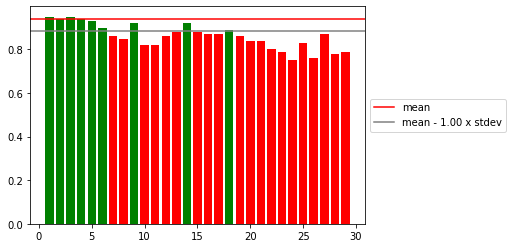


duration of test: 7 minutes




In [10]:
#size batch is 100, sequential splitting method (last parameter = 0)
run_test('real-world/spam_dataset.csv', 4405, 1468, 100, None, False, 0)

dataset: real-world/spam_dataset.csv
size dataset: 4368, size training: 1468, size testing batch: 100
features are not scaled
time-based splitting method

model: RandomForestClassifier
training mean: 0.9318308380919963 , training std: 0.018469935568034248
detected batches: [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


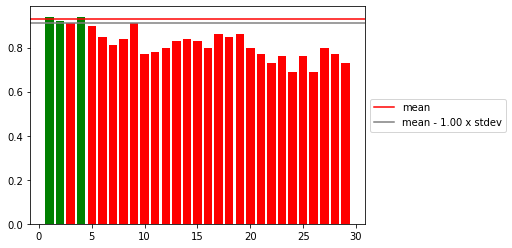


duration of test: 5 minutes




In [11]:
#size batch is 100, time-based splitting method (last parameter = 1)
run_test('real-world/spam_dataset.csv', 4405, 1468, 100, None, False, 1)

dataset: real-world/spam_dataset.csv
size dataset: 4368, size training: 1468, size testing batch: 50
features are not scaled
sequential splitting method

model: RandomForestClassifier
training mean: 0.9596000000000001 , training std: 0.04069201395851526
detected batches: [11, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 37, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58]


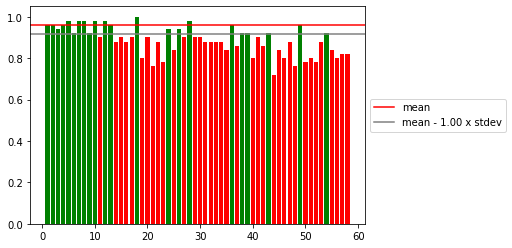


duration of test: 6 minutes




In [12]:
#size batch is 50, sequential splitting method
run_test('real-world/spam_dataset.csv', 4405, 1468, 50, None, False, 0)

dataset: real-world/spam_dataset.csv
size dataset: 4368, size training: 1468, size testing batch: 50
features are not scaled
time-based splitting method

model: RandomForestClassifier
training mean: 0.9350294657782604 , training std: 0.017823212505983253
detected batches: [1, 3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


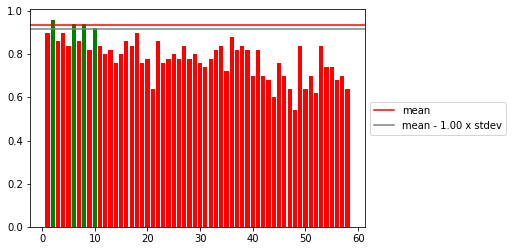


duration of test: 5 minutes




In [13]:
#size batch is 50, time-based splitting method
run_test('real-world/spam_dataset.csv', 4405, 1468, 50, None, False, 1)

dataset: real-world/spam_dataset.csv
size dataset: 4388, size training: 1468, size testing batch: 20
features are not scaled
sequential splitting method

model: RandomForestClassifier
training mean: 0.965 , training std: 0.051234753829797995
detected batches: [10, 14, 21, 26, 32, 33, 35, 36, 37, 39, 40, 41, 42, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 62, 63, 67, 68, 72, 73, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 91, 92, 93, 95, 97, 98, 99, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 131, 132, 135, 136, 137, 138, 139, 141, 142, 143, 145]


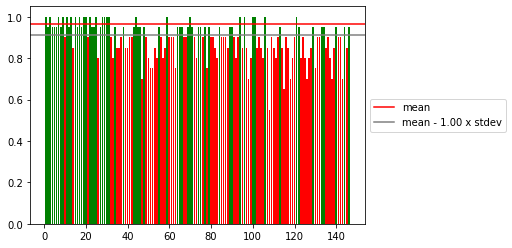


duration of test: 7 minutes




In [14]:
#size batch is 20, sequential splitting method
run_test('real-world/spam_dataset.csv', 4405, 1468, 20, None, False, 0)

dataset: real-world/spam_dataset.csv
size dataset: 4388, size training: 1468, size testing batch: 20
features are not scaled
time-based splitting method

model: RandomForestClassifier
training mean: 0.9349459298736769 , training std: 0.013474694244593181
detected batches: [2, 10, 11, 14, 17, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 90, 92, 93, 95, 97, 98, 99, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]


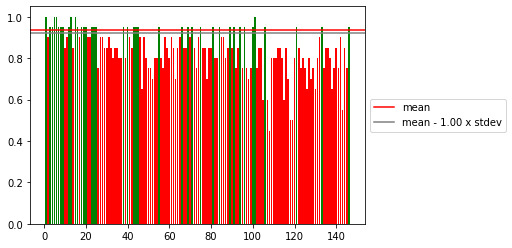


duration of test: 5 minutes




In [15]:
#size batch is 20, time-based splitting method
run_test('real-world/spam_dataset.csv', 4405, 1468, 20, None, False, 1)